# 实例：用随机森林回归填补缺失值
我们从现实中收集的数据，几乎不可能是完美无缺的，往往都会有一些缺失值。面对缺失值，很多人选择的方式是
直接将含有缺失值的样本删除，这是一种有效的方法，但是有时候填补缺失值会比直接丢弃样本效果更好，即便我
们其实并不知道缺失值的真实样貌。在sklearn中，我们可以使用**sklearn.impute.SimpleImputer**来轻松地将均
值，中值，或者其他最常用的数值填补到数据中，在这个案例中，我们将使用均值，0，和随机森林回归来填补缺
失值，并验证四种状况下的拟合状况，找出对使用的数据集来说最佳的缺失值填补方法。

### 1、导入需要的库

In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

%matplotlib inline

### 2、 以波士顿数据集为例，导入完整的数据集并探索

In [10]:
boston = load_boston()
# 总共506*13=6578个数据
boston.data.shape

(506, 13)

In [12]:
# 无缺失值
x_full, y_full = boston.data, boston.target 
n_samples = x_full.shape[0]  # 样本数
n_features = x_full.shape[1]   # 特征数

### 3、为完整数据集放入缺失值

In [13]:
# 首先确定我们希望放入的缺失数据的比例，在这里我们假设是50%，那总共就要有3289个数据缺失
rng = np.random.RandomState(0)  # 确认随机树种子
missing_rate = 0.5 
# np.floor向下取整，返回.0格式的浮点数
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))  

In [29]:
# 所有数据要随机遍布在数据集的各行各列当中，而一个缺失的数据会需要一个行索引和一个列索引
# 如果能够创造一个数组，包含3289个分布在0~506中间的行索引，和3289个分布在0~13之间的列索引，那我们就可以利用索引来为数据中的任意3289个位置赋空值
# 然后我们用0，均值和随机森林来填写这些缺失值，然后查看回归的结果如何
missing_features = rng.randint(0,n_features,n_missing_samples)  # 列索引
missing_samples = rng.randint(0,n_samples,n_missing_samples)    # 行索引

#missing_samples = rng.choice(dataset.data.shape[0],n_missing_samples,replace=False)
# 我们现在采样了3289个数据，远远超过我们的样本量506，所以我们使用随机抽取的函数randint。
# 但如果我们需要的数据量小于我们的样本量506，那我们可以采用np.random.choice来抽样，
# choice会随机抽取不重复的随机数，因此可以帮助我们让数据更加分散，确保数据不会集中在一些行中

In [30]:
len(missing_features)

3289

In [31]:
len(set(zip(missing_features, missing_samples)))  # 好像有重复

2590

In [35]:
x_missing = x_full.copy()
y_missing = y_full.copy()
x_missing[missing_samples, missing_features] = np.nan
x_missing = pd.DataFrame(x_missing)
x_missing

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,0.538,6.575,NaN,NaN,1.0,296.0,NaN,396.90,4.98
1,NaN,0.0,7.07,0.0,NaN,6.421,NaN,4.9671,2.0,NaN,17.8,396.90,NaN
2,0.02729,0.0,7.07,0.0,0.469,NaN,NaN,NaN,2.0,242.0,NaN,NaN,4.03
3,0.03237,NaN,NaN,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,54.2,NaN,NaN,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,0.0,NaN,0.0,0.573,NaN,NaN,NaN,1.0,NaN,21.0,391.99,NaN
502,0.04527,0.0,11.93,NaN,NaN,6.120,76.7,2.2875,NaN,273.0,21.0,NaN,9.08
503,0.06076,0.0,NaN,0.0,0.573,NaN,91.0,NaN,NaN,273.0,21.0,NaN,5.64
504,0.10959,0.0,NaN,NaN,0.573,6.794,89.3,2.3889,1.0,273.0,NaN,393.45,6.48


In [46]:
# 缺失值数量跟上面对上了
x_missing.isnull().sum().sum()

2590

### 4、 使用0和均值填补缺失值

In [48]:
# 使用均值填补
# missing_values：缺失值的类型
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
x_missing_mean = imp_mean.fit_transform(x_missing)  # 训练fit，并且导出predict
pd.DataFrame(x_missing_mean).isnull().sum().sum()

0

In [52]:
# 使用0填补，constant：常数
imp_0 = SimpleImputer(missing_values=np.nan, strategy='constant' ,fill_value=0)
x_missing_0 = imp_0.fit_transform(x_missing)
pd.DataFrame(x_missing_0).isnull().sum().sum()

0

### 5、使用随机森林填补缺失值

使用随机森林回归填补缺失值
任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能够实现这个过程，是因为回归算法认为，特征
矩阵和标签之前存在着某种联系。实际上，标签和特征是可以相互转换的，比如说，在一个“用地区，环境，附近学校数
量”预测“房价”的问题中，我们既可以用“地区”，“环境”，“附近学校数量”的数据来预测“房价”，也可以反过来，
用“环境”，“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值，正是利用了这种思想。

对于一个有n个特征的数据来说，其中特征T有缺失值，我们就把特征T当作标签，其他的n-1个特征和原本的标签组成新
的特征矩阵。那对于T来说，它没有缺失的部分，就是我们的Y_test，这部分数据既有标签也有特征，而它缺失的部
分，只有特征没有标签，就是我们需要预测的部分。

特征T不缺失的值对应的其他n-1个特征 + 本来的标签：X_train
特征T不缺失的值：Y_train

特征T缺失的值对应的其他n-1个特征 + 本来的标签：X_test
特征T缺失的值：未知，我们需要预测的Y_test

这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。

那如果数据中除了特征T之外，其他特征也有缺失值怎么办？
答案是遍历所有的特征，从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。
填补一个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填
补下一个特征。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0来填补的特征就越来越少。当
进行到最后一个特征时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0来进行填补了，
而我们已经使用回归为其他特征填补了大量有效信息，可以用来填补缺失最多的特征。
遍历所有的特征后，数据就完整，不再有缺失值了。

In [81]:
x_missing_reg = x_missing.copy()
# argsort（）：返回对数组进行升序排序之后的索引
sortindex = np.argsort(x_missing.isnull().sum()).values

# 先填充缺失值少的特征
for i in sortindex:
    
    # 构建我们的新特征矩阵和新标签
    # 每次填充完一个特征填充下一个特征的时候都重新赋值最新的表（经过随机森林回归填充了之前的特征）
    # 避免填充的时候其他有缺失值得特征被填充为0
    df = x_missing_reg  
    # 需要填充的特征
    fillc = df.iloc[:, i]
    # df.iloc[:, df.columns != i]：把除了需要填充的那个特征以外的特征提取出来
    # pd.concat()：连接特征和标签
    df = pd.concat([df.iloc[:, df.columns != i], pd.DataFrame(y_full)], axis=1)
    
    # 在新特征矩阵中，对含有缺失值的列，进行0的填补
    df_0 = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0).fit_transform(df)
    
    # 找出我们的训练集和测试集
    # 被选中、要填充的特征中，存在值得那些，非空值---对应现在的标签（测试集结果）
    ytrain = fillc[fillc.notnull()]
    # 被选中、要填充的特征中，不存在值得那些，空值---对应现在的需要预测的数据
    # 这是我们要填充的值，需要的是ytest的所带的行索引：即下面的：x_missing_reg.iloc[:, i].isnull()
    ytest = fillc[fillc.isnull()] # 这是缺失值，需要填充的
    # 在新特征矩阵中，被选出来需要填充的特征的非空值所对应的记录---对应现在的训练集
    xtrain = df_0[ytrain.index, :]  
    # 在新特征矩阵中，被选出来需要填充的特征的空值所对应的记录---对应现在需预测的数据
    xtest = df_0[ytest.index, :]
    
    # 用随机森林回归来填补缺失值
    rfc = RandomForestRegressor(n_estimators=100)  # 实例化
    rfc = rfc.fit(xtrain, ytrain)                  # 训练
    ypredict = rfc.predict(xtest)                  # 预测
    
    # 将填补好的特征返回到我们的原始的特征矩阵中填补之前的
    # x_missing_reg.iloc[:, i].isnull() == fillc.isnull()：所有为空的行索引
    x_missing_reg.loc[x_missing_reg.iloc[:, i].isnull(), i] = ypredict

### 6、对填补好的数据进行建模

In [85]:
X = [x_full, x_missing_mean, x_missing_0, x_missing_reg]

mse = []
std = []

for x in X:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator, x, y_full, cv=5, scoring="neg_mean_squared_error").mean()
    mse.append(scores * -1)

In [89]:
# mse越小越好
[*zip(["x_full", "x_missing_mean", "x_missing_0", "x_missing_reg"], mse)]

[('x_full', 21.62860460743544),
 ('x_missing_mean', 51.985258751659856),
 ('x_missing_0', 44.63211224764124),
 ('x_missing_reg', 17.536462631372544)]

### 7、用所得结果画出条形图

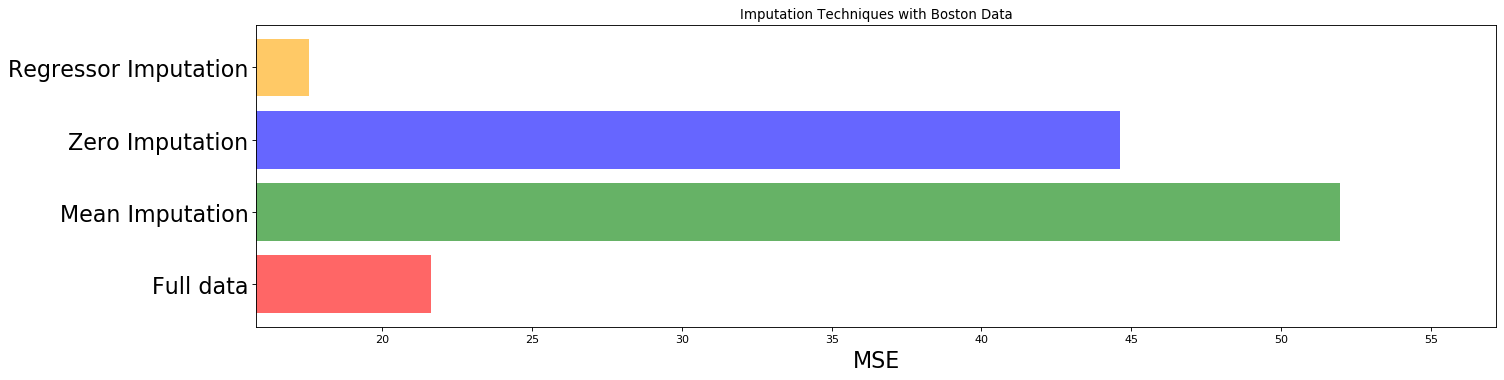

In [98]:
x_labels = ['Full data','Mean Imputation', 'Zero Imputation', 'Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=(20,5), dpi=80)
ax = plt.subplot(111) # 添加子图

for i in np.arange(len(mse)):
    ax.barh(i, mse[i], color=colors[i], alpha=0.6, align='center')

ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9,
             right=np.max(mse) * 1.1)
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE', fontsize=20)
ax.set_yticklabels(x_labels, fontsize=20)
plt.show()